In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import seaborn as sns
from dataset import Dataset
from utils import Utilities as utils
import time
# for Notebook
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Dataset Creation
Import data into a pandas dataframe using the created class Dataset

In [3]:
ds = Dataset()
print(ds.base_path)
files = os.listdir(ds.base_path+"/data/")
ds.createDataset(files)

/home/wiz/Git/LFN-Project


/home/wiz/Git/LFN-Project/dataset.py:34: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  mob_df = pd.read_csv(mobility_csv, sep=";")
/home/wiz/Git/LFN-Project/dataset.py:34: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  mob_df = pd.read_csv(mobility_csv, sep=";")
/home/wiz/Git/LFN-Project/dataset.py:34: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  mob_df = pd.read_csv(mobility_csv, sep=";")
/home/wiz/Git/LFN-Project/dataset.py:34: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  mob_df = pd.read_csv(mobility_csv, sep=";")


Now we apply the cleanup pre-processing onto the dataframe, in which we also filter the columns we need

In [4]:
# Select only needed for the analysis 
ds.applyPreprocessing(columns=["Participants","Mobility Duration", "Sending Country Code", "Receiving Country Code",
                               "Special Needs", "Fewer Opportunities", "Participant Profile",
                               "Sending Organization", "Receiving Organization", "Receiving Organisation Erasmus Code",
                               "GroupLeader", "Sending Organisation Erasmus Code", "Education Level"])
# Remove all NaN values
ds.cleanDataframe()

Removed 13 columns
Removed 126 rows


Filter Data (if we want)

In [5]:
# Select only the eramus students researchers from Italy
# ds.applyFilter(column="Sending Country Code", value="IT")
# Select only students currently under bachelor degree
ds.applyFilter(column="Education Level", value="ISCED-7", criterion='contains')

## Graph creation
We can now go ahead and create our graph, again using the Dataset class 

In [6]:
from graph import CustomGraph as Graph

The graph are created starting from the edges: the networkX library automatically creates the nodes from the edges.

Creation of Graph CountryGraph

In [26]:
import networkx as nx
import pandas as pd
edges = pd.DataFrame({"source" : ds.df["Sending Country Code"],
                      "target" : ds.df["Receiving Country Code"],
                      "weight" : ds.df["Participants"]
                         })
edges = edges.groupby(['source', 'target']).sum().reset_index()
CountryGraph = nx.from_pandas_edgelist(edges, "source", "target", "weight", nx.DiGraph())
display(len(CountryGraph), len(edges))

151

3420

In [8]:
edges.to_csv('edges/country_edges.csv', index=False)

Example of the result with Germany

In [9]:
print("Sum of the exiting participants: ", sum(e[2]['weight'] for e in CountryGraph.out_edges("DE", data=True)))
print("Total Neighbors:",CountryGraph.degree(("DE")))
print("Out Degree:", CountryGraph.out_degree("DE"))
print("In Degree:", CountryGraph.in_degree("DE"))

Sum of the exiting participants:  54069.0
Total Neighbors: 198
Out Degree: 95
In Degree: 103


In [10]:
#Code to visualize the first nodes of the graph with their edges
nodes = list(CountryGraph.nodes())
first_nodes = nodes[:100]
G = nx.subgraph(CountryGraph, first_nodes)

# Visualization with newtorkx (not working very well)
#nx.draw_networkx_nodes(G,pos=nx.spring_layout(G))
#nx.draw_networkx_edges(G,pos=nx.spring_layout(G))
#nx.draw_networkx_edge_labels(G,pos=nx.spring_layout(G))

# Code to visualize the graph with PYVIS tool
from pyvis.network import Network
net = Network(directed=True)
#net.from_nx(CountryGraph)
net.from_nx(G)
net.show("graph.html")

Creation of UniNodes Graph

In [28]:
import networkx as nx
import pandas as pd
edges = pd.DataFrame({"source" : ds.df["Sending Organization"],
                      "target" : ds.df["Receiving Organization"],
                      "weight" : ds.df["Participants"]
                         })
edges = edges.groupby(["source", "target"])["weight"].sum().reset_index()                         
UniNodes = nx.from_pandas_edgelist(edges, "source", "target", "weight", nx.DiGraph())
display(len(UniNodes), len(edges))

76816

185126

In [12]:
edges.to_csv('edges/uni_edges.csv', index=False)

Example of the result with UNIVERSITA DEGLI STUDI DI PADOVA

In [13]:
print("Sum of the exiting participants: ", sum(e[2]['weight'] for e in UniNodes.out_edges("UNIVERSITA DEGLI STUDI DI PADOVA", data=True)))
print("Total Neighbors:",UniNodes.degree(("UNIVERSITA DEGLI STUDI DI PADOVA")))
print("Out Degree:", UniNodes.out_degree("UNIVERSITA DEGLI STUDI DI PADOVA"))
print("In Degree:", UniNodes.in_degree("UNIVERSITA DEGLI STUDI DI PADOVA"))

Sum of the exiting participants:  5278.0
Total Neighbors: 1479
Out Degree: 1093
In Degree: 386


## PageRank
implementation from Networkx library

Computation of PageRank on CountryGraph

In [14]:
start = time.time()
_ranks = nx.pagerank(CountryGraph, weight='weight')
end = time.time()
print(f"pagerank: {end - start}")
ranks = sorted(_ranks.items(), key=lambda x: x[1], reverse=True)
CountryGraph.pageranks = dict(ranks)

# Standardize the results
mean = np.mean(list(CountryGraph.pageranks.values()))
print(f"mean: {mean}")
std = np.std(list(CountryGraph.pageranks.values()))
print(f"std: {std}")
CountryGraph.pageranks = {k: (v) / std for k, v in CountryGraph.pageranks.items()}

pagerank: 0.00979924201965332
mean: 0.006622516556291391
std: 0.008877944141010948


In [15]:
country_rank_df = pd.DataFrame(CountryGraph.pageranks, index=['PageRank']).T
#country_rank_df.index.name = 'Country'
country_rank_df.columns = ['PageRank']
display(country_rank_df)

,PageRank
FR,5.705275
IT,4.779821
DE,4.527102
TN,4.410451
ES,4.169602
...,...
LS,0.117024
LY,0.117024
PA,0.117024
SY,0.117024


Computation of PageRank on UniNodes

In [16]:
# Measure computation time
start = time.time()
_ranks = nx.pagerank(UniNodes, weight='weight')
end = time.time()
print(f"pagerank: {end - start}")

ranks = sorted(_ranks.items(), key=lambda x: x[1], reverse=True)
UniNodes.pageranks = dict(ranks)

# Standardize the results
mean = np.mean(list(UniNodes.pageranks.values()))
print(f"mean: {mean}")
std = np.std(list(UniNodes.pageranks.values()))
print(f"std: {std}")
UniNodes.pageranks = {k: (v) / std for k, v in UniNodes.pageranks.items()}

pagerank: 2.0881154537200928
mean: 1.3018121224753656e-05
std: 1.3010576174260168e-05


In [17]:
uni_rank_df = pd.DataFrame(UniNodes.pageranks, index=['PageRank']).T
#uni_rank_df.index.name = 'University'
uni_rank_df.columns = ['PageRank']
display(uni_rank_df)

,PageRank
UNIVERSIDADE DE LISBOA,46.915553
UNIVERSITA DEGLI STUDI DI ROMA LA SAPIENZA,43.114461
Eesti Kunstiakadeemia,40.702512
UNIVERSITA DEGLI STUDI DI PADOVA,39.536863
APLICAPROPOSTA LDA,38.750529
...,...
Российская академия народного хозяйства и государственной службы при Президенте Российской Федерации,0.868007
Уральский федеральный университет,0.868007
"შპს ""საქართველოს საავიაციო უნივერსიტეტი""",0.868007
�STERREICHISCHE POST AG,0.868007


## HITS
implementation from Networkx library

Computation of HITS on CountryGraph

In [18]:
start = time.time()
(hubs, authorities) = nx.hits(CountryGraph)
end = time.time()
print(f"nx.hits: {end - start} seconds")


nx.hits: 0.010076045989990234 seconds


In [19]:

ranks_h = sorted(hubs.items(), key=lambda x: x[1], reverse=True)
CountryGraph.hubs = dict(ranks_h)
ranks_a = sorted(authorities.items(), key=lambda x: x[1], reverse=True)
CountryGraph.authorities = dict(ranks_a)

# standardize the results
mean = np.mean(list(CountryGraph.hubs.values()))
print(f"hubs mean: {mean}")
std = np.std(list(CountryGraph.hubs.values()))
print(f"hubs std: {std}")
CountryGraph.hubs = {k: (v) / std for k, v in CountryGraph.hubs.items()}

mean = np.mean(list(CountryGraph.authorities.values()))
print(f"authorities mean: {mean}")
std = np.std(list(CountryGraph.authorities.values()))
print(f"authorities std: {std}")
CountryGraph.authorities = {k: (v) / std for k, v in CountryGraph.authorities.items()}

country_hubs_df = pd.DataFrame(CountryGraph.hubs, index=['Hubs']).T
country_auth_df = pd.DataFrame(CountryGraph.authorities, index=['Authorities']).T

country_hubs_df.reset_index(inplace=True)
country_hubs_df = country_hubs_df.rename(columns={'index':'Country'})

country_auth_df.reset_index(inplace=True)
country_auth_df = country_auth_df.rename(columns={'index':'Country'})

display(country_hubs_df)
display(country_auth_df)

hubs mean: 0.0066225165562913925
hubs std: 0.03711468161060558
authorities mean: 0.006622516556291391
authorities std: 0.03478581355779378


,Country,Hubs
0,TN,11.632965
1,VN,3.196292
2,DZ,2.038932
3,EG,2.001366
4,ME,1.042134
...,...,...
146,KP,-0.000000
147,SO,-0.000000
148,CH,-0.000000
149,TL,-0.000000


,Country,Authorities
0,FR,9.931873
1,IT,5.749203
2,DE,3.982994
3,ES,1.864962
4,PL,1.623069
...,...,...
146,LS,-0.000000
147,LY,-0.000000
148,PA,-0.000000
149,SY,-0.000000


Computation of HITS on UniNodes

In [20]:
start = time.time()
(hubs, authorities) = nx.hits(UniNodes)
end = time.time()
print(f"nx.hits: {end - start} seconds")

nx.hits: 2.626953125 seconds


In [21]:

ranks_h = sorted(hubs.items(), key=lambda x: x[1], reverse=True)
UniNodes.hubs = dict(ranks_h)
ranks_a = sorted(authorities.items(), key=lambda x: x[1], reverse=True)
UniNodes.authorities = dict(ranks_a)

mean = np.mean(list(UniNodes.hubs.values()))
print(f"hubs mean: {mean}")
std = np.std(list(UniNodes.hubs.values()))
print(f"hubs std: {std}")
UniNodes.hubs = {k: (v) / std for k, v in UniNodes.hubs.items()}

mean = np.mean(list(UniNodes.authorities.values()))
print(f"authorities mean: {mean}")
std = np.std(list(UniNodes.authorities.values()))
print(f"authorities std: {std}")
UniNodes.authorities = {k: (v) / std for k, v in UniNodes.authorities.items()}

uni_hubs_df = pd.DataFrame(UniNodes.hubs, index=['Hubs']).T
uni_auth_df = pd.DataFrame(UniNodes.authorities, index=['Authorities']).T

uni_hubs_df.reset_index(inplace=True)
uni_hubs_df = uni_hubs_df.rename(columns={'index':'University'})

uni_auth_df.reset_index(inplace=True)
uni_auth_df = uni_auth_df.rename(columns={'index':'University'})

display(uni_hubs_df)
display(uni_auth_df)

hubs mean: 1.3018121224744843e-05
hubs std: 0.0002273261055353457
authorities mean: 1.3018121224744842e-05
authorities std: 0.00017940349596332387


,University,Hubs
0,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,8.830402e+01
1,UNIVERSITA DEGLI STUDI DI PADOVA,7.268638e+01
2,POLITECNICO DI MILANO,6.975872e+01
3,UNIVERSITA DEGLI STUDI DI ROMA LA SAPIENZA,6.811579e+01
4,UNIVERSIDADE DE LISBOA,5.560943e+01
...,...,...
76811,Lycée professionnel Fernand Dégrugillier,-6.942498e-21
76812,Zavod za gluhe in naglusne Ljubljana,-9.243981e-21
76813,"Dél-Alföld - Európai Unió Gazdasági, Kulturáli...",-1.069944e-20
76814,Srednja skola Buzet,-1.908089e-20


,University,Authorities
0,UNIVERSIDADE DE LISBOA,8.135427e+01
1,NORGES TEKNISK-NATURVITENSKAPELIGE UNIVERSITET...,6.572690e+01
2,UNIVERSITAT POLITECNICA DE CATALUNYA,5.969185e+01
3,UNIVERSITAT POLITECNICA DE VALENCIA,5.589549e+01
4,KATHOLIEKE UNIVERSITEIT LEUVEN,5.108606e+01
...,...,...
76811,Colegio Helios S.L,-9.305574e-19
76812,EUROPA: MOVILIDAD ESTUDIANTIL,-1.023151e-18
76813,EUROPA TRAINING (UK) LTD,-1.261222e-18
76814,Srednja tehniska sola Koper-Scuola media techn...,-1.713664e-18


## Closeness Centrality

In [22]:
start = time.time()
_cc = nx.closeness_centrality(CountryGraph, distance='weight')
end = time.time()
print(f"nx.cc: {end - start} seconds")


nx.cc: 0.4600980281829834 seconds


In [23]:
cc = sorted(_cc.items(), key=lambda x: x[1], reverse=True)
CountryGraph.centrality = dict(cc)

# Standardize the results
mean = np.mean(list(CountryGraph.centrality.values()))
std = np.std(list(CountryGraph.centrality.values()))
CountryGraph.centrality = {k: (v) / std for k, v in CountryGraph.centrality.items()}

# Visualize data
rank_df = pd.DataFrame(CountryGraph.pageranks, index=['Country']).T
rank_df.index.name = 'Country'
rank_df.columns = ['Centrality Score']
display(rank_df)

,Centrality Score
Country,
FR,5.705275
IT,4.779821
DE,4.527102
TN,4.410451
ES,4.169602
...,...
LS,0.117024
LY,0.117024
PA,0.117024


In [24]:
start = time.time()
_cc = nx.closeness_centrality(UniNodes, distance='weight')
end = time.time()
print(f"nx.cc: {end - start} seconds")

KeyboardInterrupt: 

## Plots

### PageRank plot

PageRank Scores CountryGraph

In [20]:
top_country_PR = country_rank_df[:25]
top_country_PR.reset_index(inplace=True)
top_country_PR = top_country_PR.rename(columns={'index':'Country'})

display(top_country_PR)

,Country,PageRank
0,FR,5.705275
1,IT,4.779821
2,DE,4.527102
3,TN,4.410451
4,ES,4.169602
5,VN,3.818511
6,PL,3.570939
7,EG,3.318511
8,RO,2.181094
9,BE,2.112036


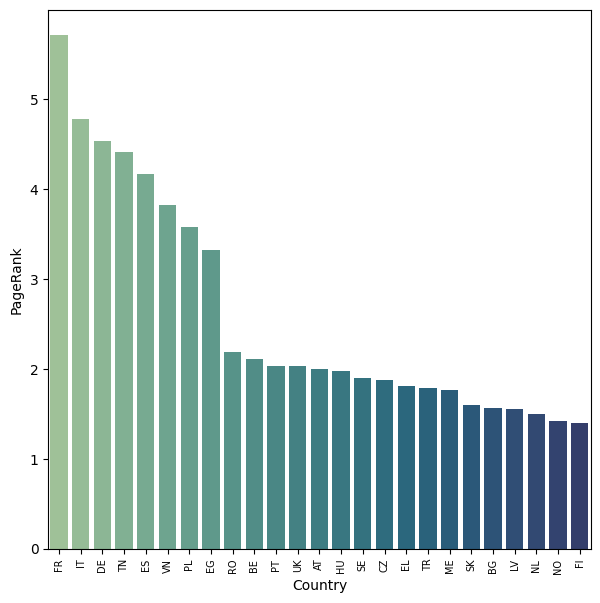

In [21]:
fig, ax = plt.subplots(figsize=(7, 7))
sns.barplot(top_country_PR, x="Country", y="PageRank", ax=ax, palette="crest")
#plt.xticks([])
plt.xticks(rotation=90,fontsize=7)

plt.savefig("plotsImg/country_PR_scores.png")
plt.show()

PageRank Scores UniNodes

In [22]:
top_uni_PR = uni_rank_df[:25]
top_uni_PR.reset_index(inplace=True)
top_uni_PR = top_uni_PR.rename(columns={'index':'University'})

display(top_uni_PR)

,University,PageRank
0,UNIVERSIDADE DE LISBOA,46.915553
1,UNIVERSITA DEGLI STUDI DI ROMA LA SAPIENZA,43.114461
2,Eesti Kunstiakadeemia,40.702512
3,UNIVERSITA DEGLI STUDI DI PADOVA,39.536863
4,APLICAPROPOSTA LDA,38.750529
5,VYTAUTO DIDZIOJO UNIVERSITETAS,38.479531
6,POLITECNICO DI MILANO,37.903093
7,UNIVERZA V LJUBLJANI,36.772517
8,Masarykova univerzita,36.562986
9,UNIVERSIDADE DO PORTO,35.556041


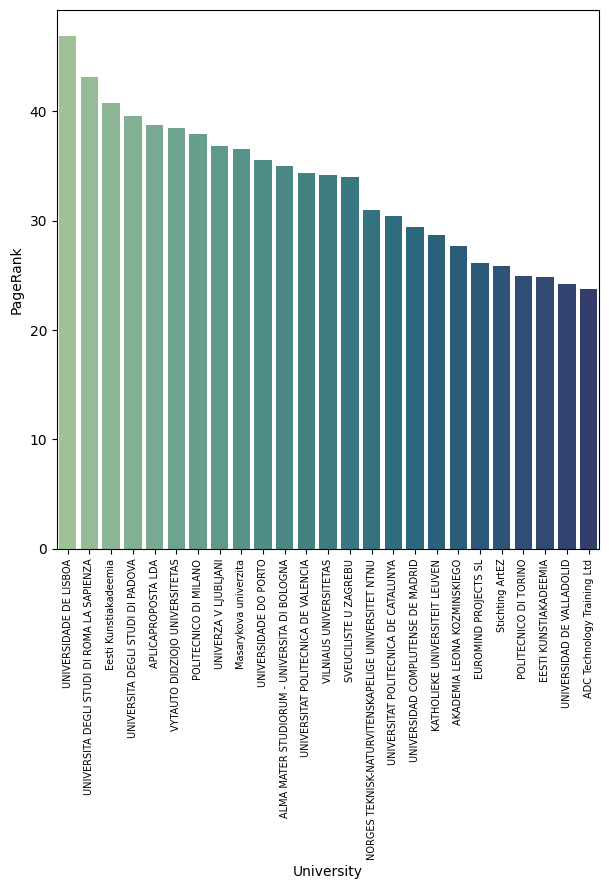

In [23]:
fig, ax = plt.subplots(figsize=(7, 7))
sns.barplot(top_uni_PR, x="University", y="PageRank", ax=ax, palette="crest")
#plt.xticks([])
plt.xticks(rotation=90,fontsize=7)

plt.savefig("plotsImg/uni_PR_scores.png")
plt.show()

### HITS plot

Hubs Scores CountryGraph

Top 10 hubs scores


,Country,Hubs
0,TN,11.632965
1,VN,3.196292
2,DZ,2.038932
3,EG,2.001366
4,ME,1.042134
5,CI,0.460721
6,MY,0.432876
7,SY,0.361303
8,HT,0.317259
9,PK,0.273550


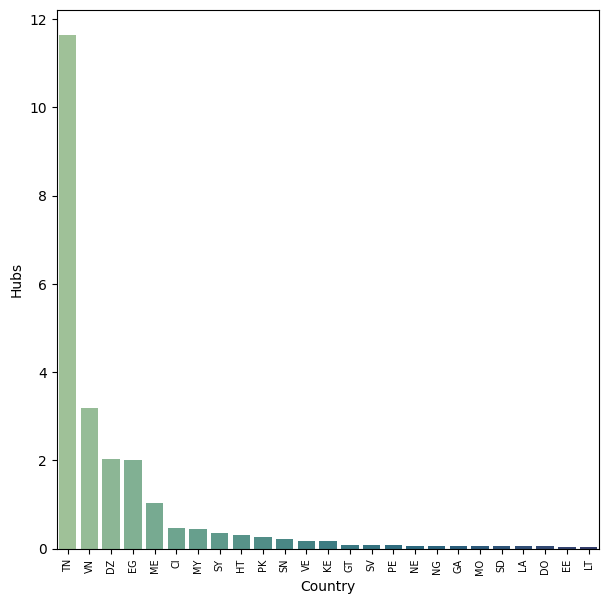

In [24]:
top_country_hubs = country_hubs_df[:25]
#top_country_hubs.reset_index(inplace=True)
#top_country_hubs = top_country_hubs.rename(columns={'index':'Country'})

print("Top 10 hubs scores")
display(top_country_hubs)

fig, ax = plt.subplots(figsize=(7, 7))
sns.barplot(top_country_hubs, x="Country", y="Hubs", ax=ax, palette="crest")
#plt.xticks([])
plt.xticks(rotation=90,fontsize=7)

plt.savefig("plotsImg/country_hubs_scores.png")
plt.show()

Authorities Scores CountryGraph

Top 10 authorities scores


,Country,Authorities
0,FR,9.931873
1,IT,5.749203
2,DE,3.982994
3,ES,1.864962
4,PL,1.623069
5,PT,0.849647
6,SE,0.719874
7,BE,0.602058
8,BG,0.596228
9,RO,0.545407


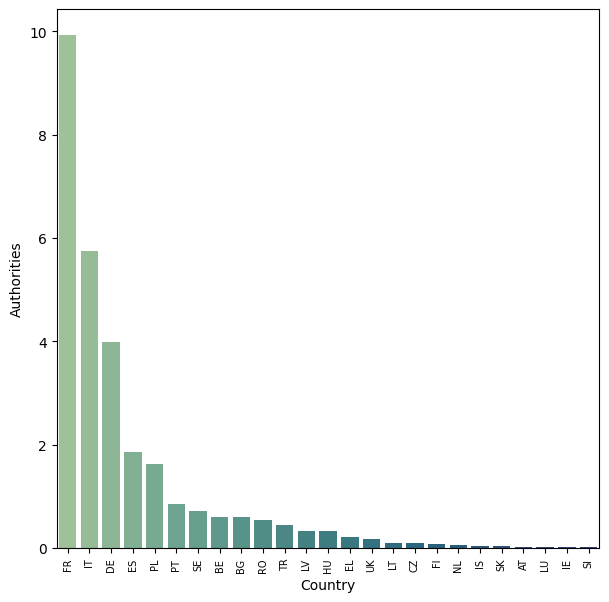

In [25]:
top_country_auth = country_auth_df[:25]
#top_country_auth.reset_index(inplace=True)
#top_country_auth = top_country_auth.rename(columns={'index':'Country'})

print("Top 10 authorities scores")
display(top_country_auth)

fig, ax = plt.subplots(figsize=(7, 7))
sns.barplot(top_country_auth, x="Country", y="Authorities", ax=ax, palette="crest")
#plt.xticks([])
plt.xticks(rotation=90,fontsize=7)

plt.savefig("plotsImg/country_auth_scores.png")
plt.show()

Hubs Scores UniNodes

Top 10 hubs scores


,University,Hubs
0,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,88.304024
1,UNIVERSITA DEGLI STUDI DI PADOVA,72.686377
2,POLITECNICO DI MILANO,69.758715
3,UNIVERSITA DEGLI STUDI DI ROMA LA SAPIENZA,68.115788
4,UNIVERSIDADE DE LISBOA,55.609432
5,TECHNISCHE UNIVERSITAET MUENCHEN,49.995969
6,UNIVERSITEIT GENT,42.097082
7,RHEINISCH-WESTFAELISCHE TECHNISCHE HOCHSCHULE ...,41.263244
8,NORGES TEKNISK-NATURVITENSKAPELIGE UNIVERSITET...,41.148750
9,KATHOLIEKE UNIVERSITEIT LEUVEN,40.161146


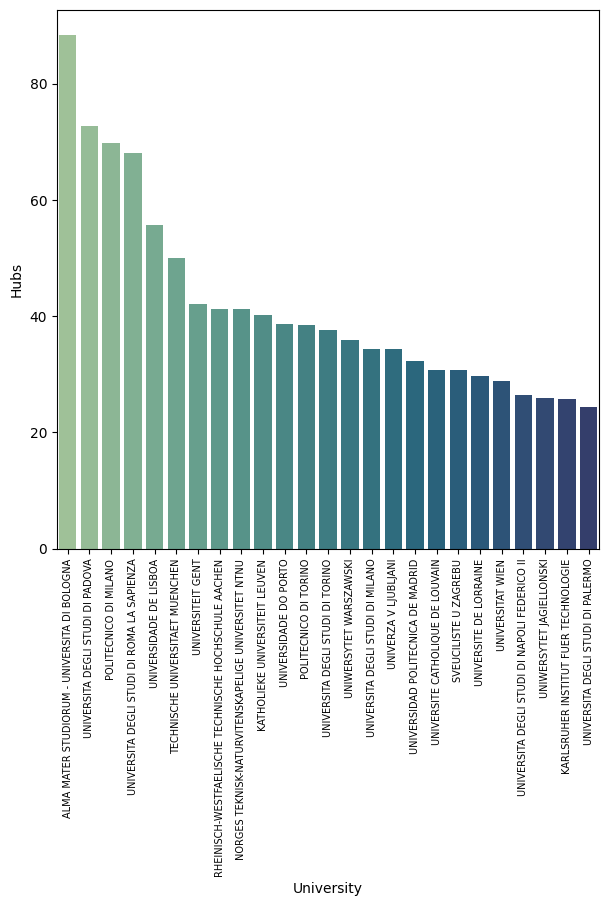

In [26]:
top_uni_hubs = uni_hubs_df[:25]
#top_uni_hubs.reset_index(inplace=True)
#top_uni_hubs = top_uni_hubs.rename(columns={'index':'University'})

print("Top 10 hubs scores")
display(top_uni_hubs)

fig, ax = plt.subplots(figsize=(7, 7))
sns.barplot(top_uni_hubs, x="University", y="Hubs", ax=ax, palette="crest")
#plt.xticks([])
plt.xticks(rotation=90,fontsize=7)

plt.savefig("plotsImg/uni_hubs_scores.png")
plt.show()

Authority Scores UniNodes

Top 10 authorities scores


,University,Authorities
0,UNIVERSIDADE DE LISBOA,81.354269
1,NORGES TEKNISK-NATURVITENSKAPELIGE UNIVERSITET...,65.726895
2,UNIVERSITAT POLITECNICA DE CATALUNYA,59.691851
3,UNIVERSITAT POLITECNICA DE VALENCIA,55.895486
4,KATHOLIEKE UNIVERSITEIT LEUVEN,51.086058
5,TECHNISCHE UNIVERSITAET MUENCHEN,50.081965
6,KUNGLIGA TEKNISKA HOEGSKOLAN,45.884966
7,UNIVERSIDAD COMPLUTENSE DE MADRID,43.345598
8,UNIVERSIDAD DE SEVILLA,41.231530
9,UNIVERSITAT DE VALENCIA,40.021007


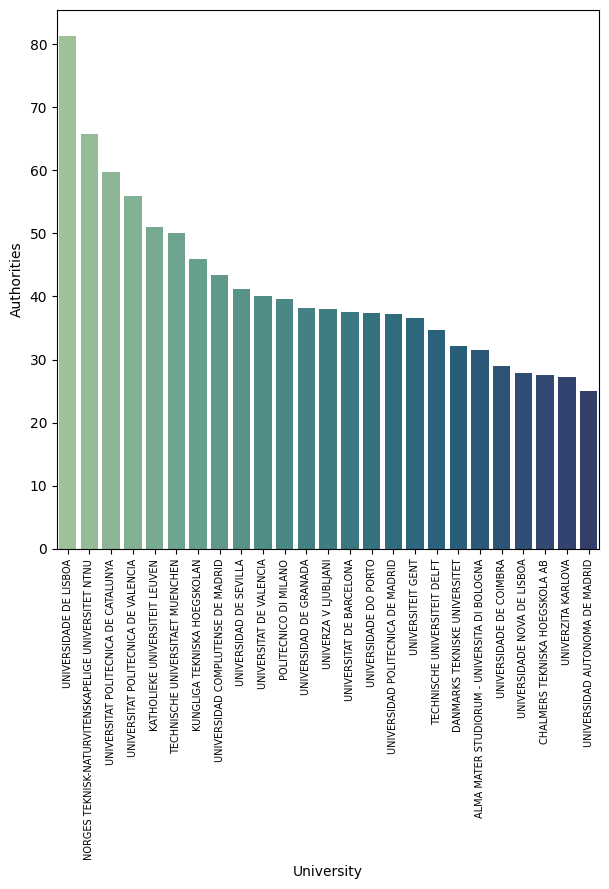

In [27]:
top_uni_auth = uni_auth_df[:25]
#top_uni_auth.reset_index(inplace=True)
#top_uni_auth = top_uni_auth.rename(columns={'index':'University'})

print("Top 10 authorities scores")
display(top_uni_auth)

fig, ax = plt.subplots(figsize=(7, 7))
sns.barplot(top_uni_auth, x="University", y="Authorities", ax=ax, palette="crest")
#plt.xticks([])
plt.xticks(rotation=90,fontsize=7)

plt.savefig("plotsImg/uni_auth_scores.png")
plt.show()

### Geographic Heatmap for Countries PageRank

-99 not found in ISOnumeric


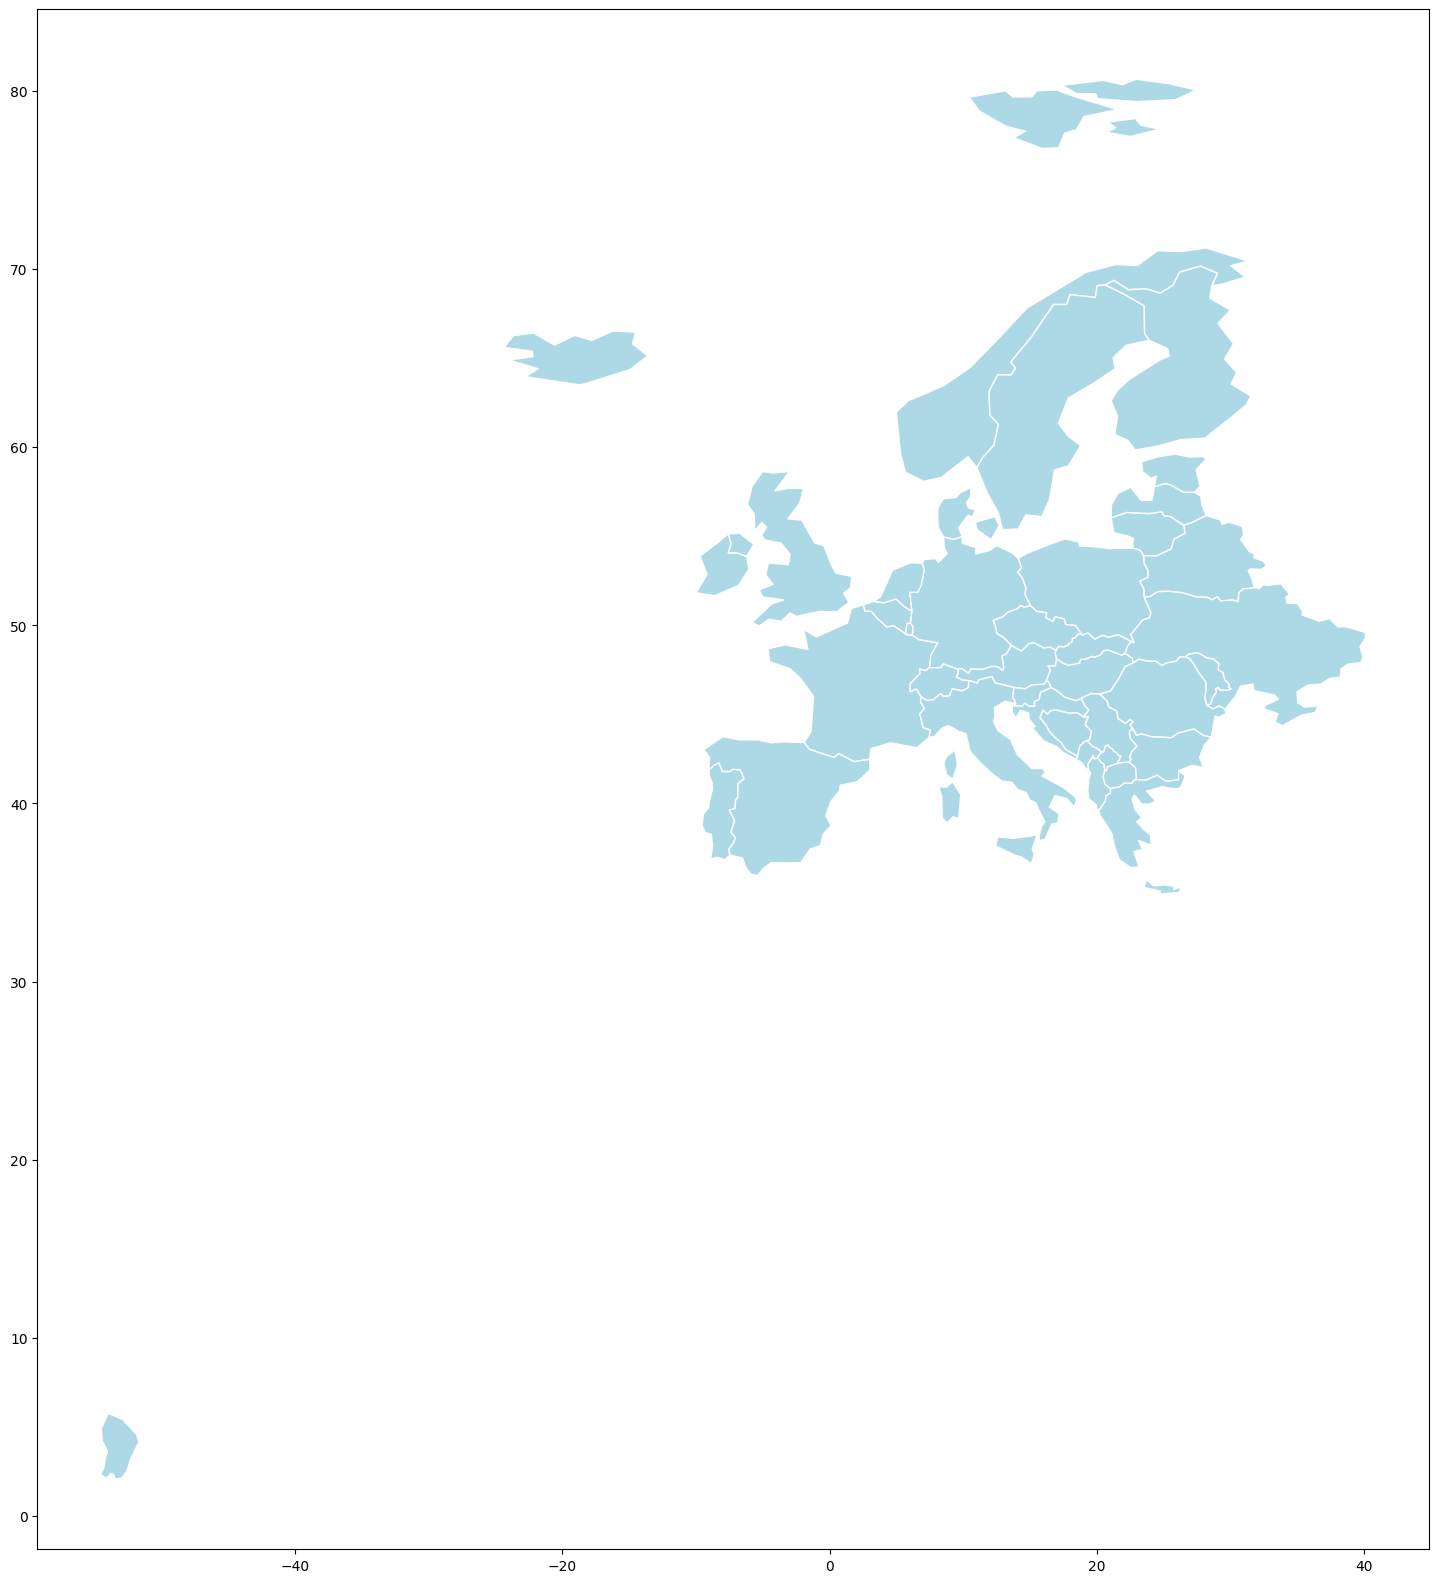

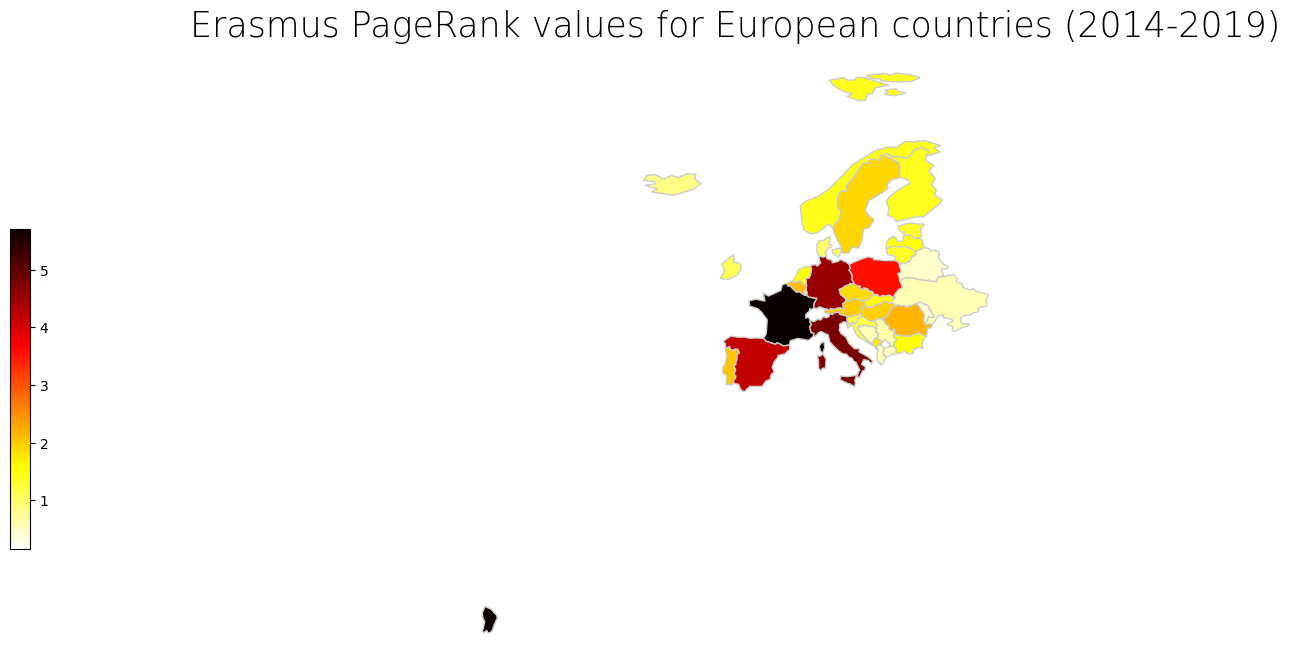

In [37]:
import geopandas as gpd
import country_converter as coco

countries = country_rank_df.copy()
countries.reset_index(inplace=True)
countries = countries.rename(columns={'index':'Country'})

# load a shapefile of countries
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# keep only Europe countries
world = world.loc[world['continent'] == 'Europe']
# dropping Russia because too big and not really useful results
world = world.drop(world.loc[world['name'] == 'Russia'].index)
world.plot(figsize=(20, 20), edgecolor='white', linewidth=1, color='lightblue')


iso3_codes = world['iso_a3'].to_list()
iso2_codes_list = coco.convert(names=iso3_codes, to='ISO2', not_found='NULL')
world['iso_a2'] = iso2_codes_list
world.drop(world.loc[world['iso_a2'] == 'NULL'].index, inplace=True)

# Merge the two dataframes
merged_df = pd.merge(left=world, right=countries, how='left', left_on='iso_a2', right_on='Country')

title = 'Erasmus PageRank values for European countries (2014-2019)'
col = 'PageRank'
vmin = merged_df[col].min()
vmax = merged_df[col].max()
#cmap = 'viridis'
#cmap = 'plasma'
#cmap ='YlOrRd'
cmap ='hot_r'

fig, ax = plt.subplots(1, figsize=(20, 8))
ax.axis('off')
merged_df.plot(column=col, ax=ax, edgecolor='0.8', linewidth=1, cmap=cmap)
ax.set_title(title, fontdict={'fontsize': '25', 'fontweight': '3'})
# Colorbar legend
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap=cmap)
sm._A = []
cbaxes = fig.add_axes([0.15, 0.25, 0.01, 0.4])
cbar = fig.colorbar(sm, cax=cbaxes)

plt.savefig("geoMaps/PR_geoMap.png")

### Geographic Heatmap for Countries with HITS

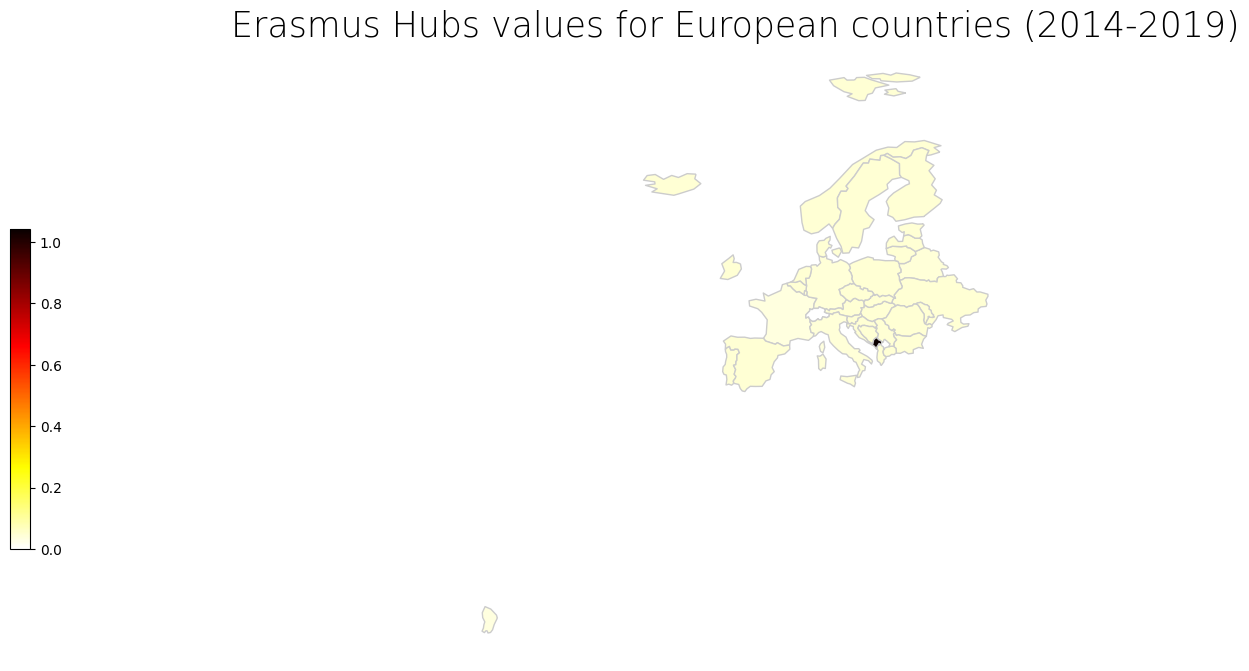

In [31]:
import geopandas as gpd
import country_converter as coco

countries = country_hubs_df.copy()

# Merge the two dataframes
merged_df = pd.merge(left=world, right=countries, how='left', left_on='iso_a2', right_on='Country')

title = 'Erasmus Hubs values for European countries (2014-2019)'
col = 'Hubs'
vmin = merged_df[col].min()
vmax = merged_df[col].max()
#cmap = 'viridis'
#cmap = 'plasma'
#cmap ='YlOrRd'
cmap ='hot_r'

fig, ax = plt.subplots(1, figsize=(20, 8))
ax.axis('off')
merged_df.plot(column=col, ax=ax, edgecolor='0.8', linewidth=1, cmap=cmap)
ax.set_title(title, fontdict={'fontsize': '25', 'fontweight': '3'})
# Colorbar legend
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap=cmap)
sm._A = []
cbaxes = fig.add_axes([0.15, 0.25, 0.01, 0.4])
cbar = fig.colorbar(sm, cax=cbaxes)

plt.savefig("geoMaps/Hubs_geoMap.png")

In [32]:
import geopandas as gpd
import country_converter as coco

countries = country_auth_df.copy()

# Merge the two dataframes
merged_df = pd.merge(left=world, right=countries, how='left', left_on='iso_a2', right_on='Country')

title = 'Erasmus Authorities values for European countries (2014-2019)'
col = 'Authorities'
vmin = merged_df[col].min()
vmax = merged_df[col].max()
#cmap = 'viridis'
#cmap = 'plasma'
#cmap ='YlOrRd'
cmap ='hot_r'

fig, ax = plt.subplots(1, figsize=(20, 8))
ax.axis('off')
merged_df.plot(column=col, ax=ax, edgecolor='0.8', linewidth=1, cmap=cmap)
ax.set_title(title, fontdict={'fontsize': '25', 'fontweight': '3'})
# Colorbar legend
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap=cmap)
sm._A = []
cbaxes = fig.add_axes([0.15, 0.25, 0.01, 0.4])
cbar = fig.colorbar(sm, cax=cbaxes)

plt.savefig("geoMaps/Auth_geoMap.png")

NameError: name 'europe' is not defined

In [45]:
country_rank_df

,PageRank
FR,5.719243
IT,4.760962
DE,4.507946
TN,4.419083
ES,4.150749
...,...
LS,0.117110
LY,0.117110
PA,0.117110
SY,0.117110
